# PyTorch Workflow

Here we while explore an example of an end-to-end workflow.

1. Data (prepare and load)
2. Build model
3. Fitting the model to the data (training)
4. Making prediction and evaluating a model
5. Saving and loading a model
6. Putting it all together

To start we are going to need the nn module. This contains all the necesry parts for neural networks.

In [34]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'1.12.1'

## 1. Data (Prepare and load)

The data used in machine learning can come in almost any shape (spreadsheet, images, videos, text,...).

To use this data we have two steps
1. get data into a numerical representation (tensors)
2. Build or train model to see patern in the data

Lets create some * known * data to show case this using the liniear regresion formula. We will use this formula to make a straight line with known paramaters.

In [35]:
weight = 0.7    # b
bias = 0.3      # a

start  = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # creates a tesor with one dimesion with values starting from 0 to 1
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [36]:
len(X), len(y)

(50, 50)

### Splitting data

when training a model you want to split your data in:
* a training set (60%-80%)
* a validation set (10%-20%)
* a test set (10%-20%)

if it is succesfull on each set, the model should be cappable of predicting data it has never seen before. an other way of  doind this is using sklearn train set split.

In [37]:
train_split = int(0.8 * len(X))
x_train, y_train = X[:train_split], y[:train_split]
x_test, y_test = X[train_split:], y[train_split:]

len(x_train), len(y_train), len(x_test), len(y_test)

(40, 40, 10, 10)

to visuelize these sets we can use Mathplot.

### Visualizing data

In [38]:
def plot_predictions(train_data=x_train, train_labels=y_train, test_data=x_test, test_labels=y_test, predictions=None):
    """
    Plots training data, test data, and compares predictions.
    :param train_data:
    :param train_labels:
    :param test_data:
    :param test_labels:
    :param predictions:
    :return:
    """

    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    plt.legend(prop={'size': 14})

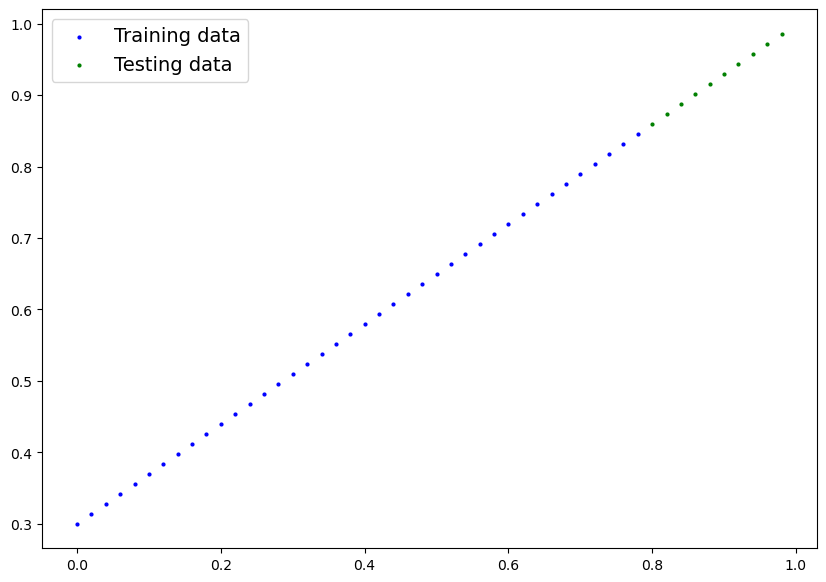

In [39]:
plot_predictions()

## 2. Builing model

We will now be building a linear regresion model, to form prediction based on the data set. To build this module we need to inheirit the `nn.Module`.

Our model will take the following steps:
1. Start with random values (weight & bias)
2. Look at training data and adjust the random values to match closer with the training data

This is done through two main algoritmnes:
1. Gradient descent (`requires_grad=True`)
2. Backpropagation

In [40]:
class LinearRegressionModel(nn.Module):  # inheirit nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # Build a random tensor on a gradiant curve of the type float
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # liniear regresion formula

### PyTorch model building essentials

* torch.nn - contains all the building for coputational graph
* torch.nn.Parameters - what models should our parameters try and learn
* torch.nn.Module - the base clase for all nrural network models
* torch.optim - optimizers that will help with gradient descent
* def forward - All nn.Module subclasses require you to overide forward. this method is what happens in the forward computation.

### Checking the contents of our PyTorch model

Now we have created a model, lets take a look at what is inside. We can do this by using `.parameters()`

In [41]:
# Create a random seed
torch.manual_seed(75)

# Create a model based on predefined class
model_0 = LinearRegressionModel()

# List paramaters
list(model_0.parameters())

[Parameter containing:
 tensor([0.1654], requires_grad=True),
 Parameter containing:
 tensor([0.4144], requires_grad=True)]

In [42]:
# Check parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.1654])), ('bias', tensor([0.4144]))])

### Maing predictions

to check our models predictive power, lets see well it predicts `y_test` based on `x_test`. To do this we will use `torch.interference_mode()`. When we pass data through model, it will run it  through the forward model. `Inference_mode()` disables all tracker available when training a model, so it can be done faster.

In [43]:
with torch.inference_mode():
    y_preds = model_0(x_test)

y_preds

tensor([[0.5467],
        [0.5500],
        [0.5533],
        [0.5566],
        [0.5599],
        [0.5632],
        [0.5665],
        [0.5698],
        [0.5731],
        [0.5764]])

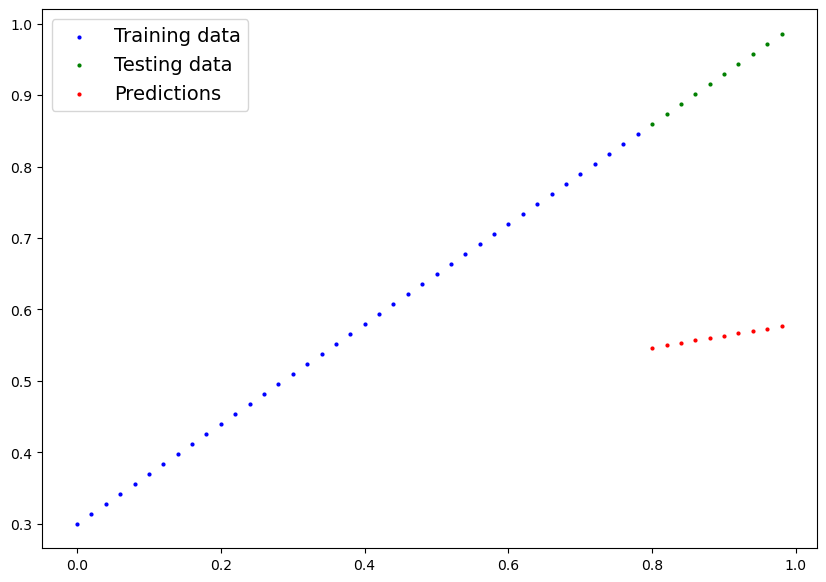

In [44]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea od training is for a model to moe from some *unknown* paramaters (these may be random) to some *known* paramaters. or iun other words from a poor to a better representation of the data.


One way to measure the quality of a model is to use a loss functions. There are some pre-build function included in the `nn` class. some of the most common ones are:

* `nn.L1Loss`: Measure the mean absolute error.
* `nn.MSELoss`

The same goes for optemizers, fjor which there are also several algoritmes. One of these is made for gradient decent

These two respand to each others changes to get closser to the right model.

### Setting up loss function and optimizer

learning rate is posibly the most important hyper paramater (paramater inside a model that we set ourselves). it sets the learning steps of our model.

In [45]:
loss_fn = nn.L1Loss()

# Stocastic gradient descent
optemizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

### Building a training and testing loop

Remeber this order you will need it a lot.

A couple of things we need in a training loop:

1. Loop through the data
2. Forward pass to make predictions on data (data moving through our models forward function) - or forward propogation
3. Calcultae the loss (compare predictions to ground truth)
4. Optimizer zero grad
5. Loss backward - moves backwards throught the network to calculate the gradients of each of the parameters of out model with respect to loss (**Backpropagation**)
6. Optmize stepp - Chnage parameters (**Gradient decent**)


In [46]:
torch.manual_seed(75)

# epoch is the amount of loops through the data
epochs = 3000

# Tracking diffrent vallues to compare diffrent experements
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode, this sets all parameters that require gradients to True
    model_0.train()

    # 1. Forward pass
    y_pred = model_0(x_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optemizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optemizer.step()

    ### Testing
    # turns off gsettings not needed for testing
    model_0.eval()

    # turns off gradient tracking
    with torch.inference_mode():
        # 1. Do forward pass
        test_pred = model_0(x_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

        # 3.

    if epoch % 10 == 0:
        # Loading meta data
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)

        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Test: 0.12763239443302155 | Test loss: 0.36069953441619873
OrderedDict([('weights', tensor([0.1657])), ('bias', tensor([0.4148]))])
Epoch: 10 | Test: 0.12465585768222809 | Test loss: 0.35345733165740967
OrderedDict([('weights', tensor([0.1690])), ('bias', tensor([0.4191]))])
Epoch: 20 | Test: 0.12200608104467392 | Test loss: 0.34657371044158936
OrderedDict([('weights', tensor([0.1722])), ('bias', tensor([0.4231]))])
Epoch: 30 | Test: 0.11941611766815186 | Test loss: 0.3398114740848541
OrderedDict([('weights', tensor([0.1755])), ('bias', tensor([0.4270]))])
Epoch: 40 | Test: 0.11721768230199814 | Test loss: 0.3335346579551697
OrderedDict([('weights', tensor([0.1786])), ('bias', tensor([0.4305]))])
Epoch: 50 | Test: 0.11501924693584442 | Test loss: 0.3272578716278076
OrderedDict([('weights', tensor([0.1817])), ('bias', tensor([0.4340]))])
Epoch: 60 | Test: 0.11311075836420059 | Test loss: 0.3214736580848694
OrderedDict([('weights', tensor([0.1847])), ('bias', tensor([0.4371]))

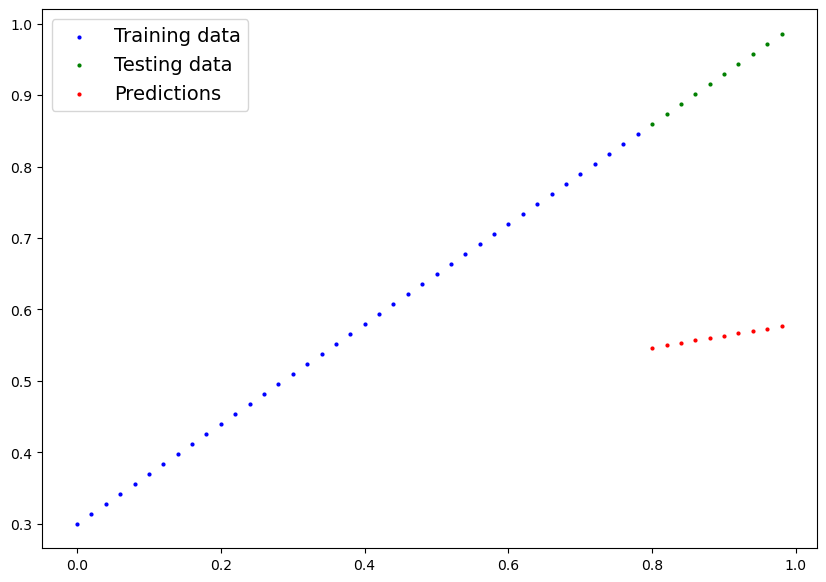

In [47]:
plot_predictions(predictions=y_preds)

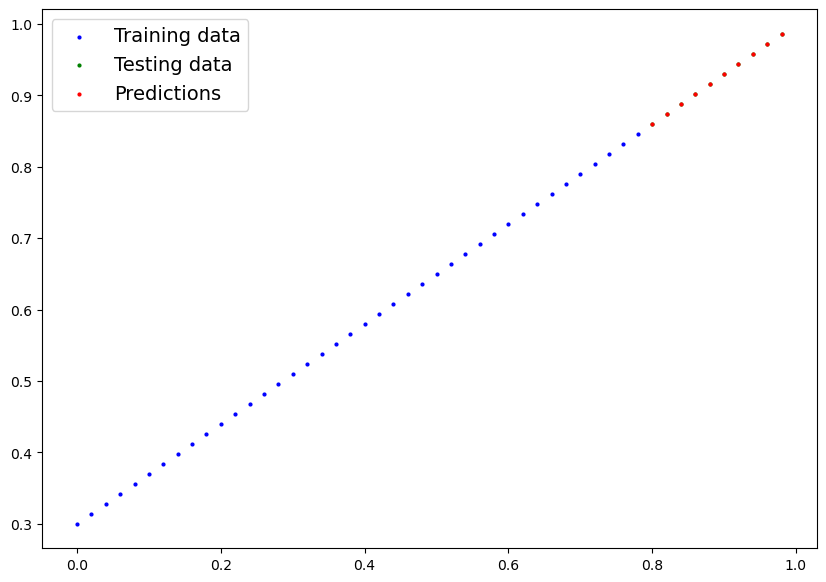

In [48]:
with torch.inference_mode():
    y_preds_news = model_0(x_test)

 
plot_predictions(predictions=y_preds_news)

### Plotting meta data from training loop

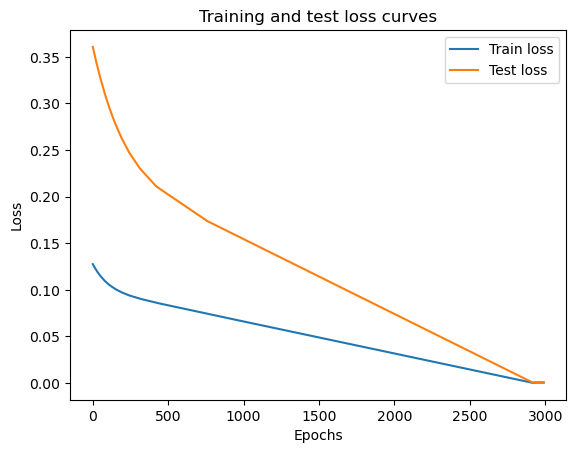

In [49]:
# Plot the loss curves
loss_values = np.array(torch.tensor(loss_values).numpy())

plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## 4. Saving a model in PyTorch

There are three main methodes used when saving and loading models in PyTorch

1. **`torch.save()`** - Save a PyTorch object in Pickle format
2. **`torch.load()`** - Load a saved PyTorch model
3. **`torch.nn.Module.load_state_dict()`** - This allows to load a model's saved state dictionary

The previously crated model will be saved in the example below

### 1. Create models directory

In [50]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

### 2. Create a model save path

In [51]:
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

### 3. Save the model state-dict

In [52]:
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


In [53]:
!dir -l models

 Volume in drive C is OSDisk
 Volume Serial Number is 4818-509D

 Directory of C:\Users\msaey\DataspellProjects\Python_handbooks\Libraries\PyTorch


 Directory of C:\Users\msaey\DataspellProjects\Python_handbooks\Libraries\PyTorch\models

03/04/2023  20:05    <DIR>          .
03/04/2023  20:05    <DIR>          ..
04/04/2023  10:25             1.063 01_pytorch_workflow_model_0.pth
               1 File(s)          1.063 bytes
               2 Dir(s)  130.582.855.680 bytes free


File Not Found


## 5. Load a  PyTorch model

In the previous part we loaded the `state_dict()` of our model as a file. now we will create a new instance of our model class and load the saved `state_dict()` into it

In [54]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6996])), ('bias', tensor([0.3006]))])

In [56]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6996])), ('bias', tensor([0.3006]))])

### Use the loaded model

Now we have loaded in the `state_dict` we can use it to generate some predictions, and lets compare these predictions to the original

In [57]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(x_test)

    y_preds = model_0(x_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go through all the above defined steps in one place. The first steps are to prepare are enviroment.

### 6.1 Set-up

1. imports
2. device-agnostic code (use GPU when available)

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.0+cu117'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


### 6.2 Data

lets recreate the previus test data, using the linear regression formula of y = wheight * x + bias

In [60]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

x = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * x + bias

x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### 6.3 Split data

In [4]:
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

len(x_train), len(y_train), len(x_test), len(y_test)

NameError: name 'x' is not defined

### 6.4 Plot data

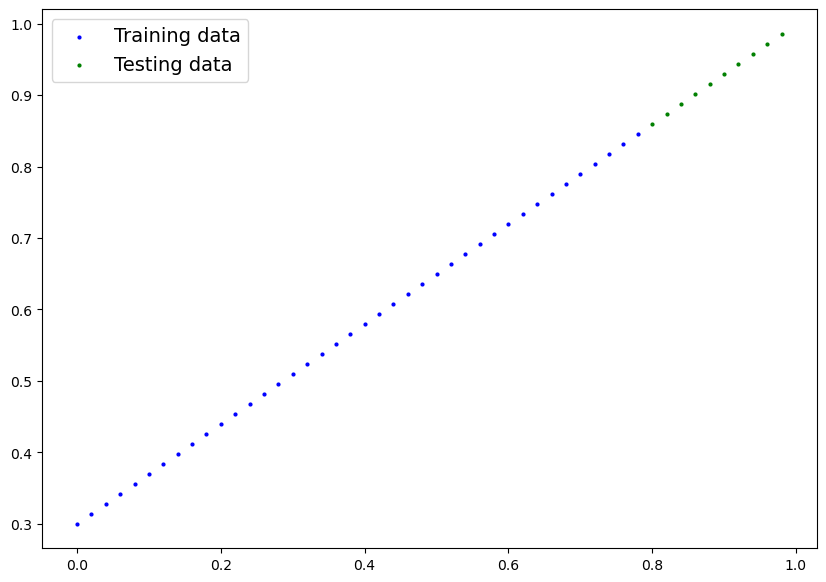

In [62]:
plot_predictions(x_train, y_train, x_test, y_test)